In [20]:
#Import các thư viện

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,r2_score,mean_squared_error,confusion_matrix,mean_absolute_error,mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [3]:
#Đọc và in ra 5 dòng đầu
df = pd.read_csv("House Prices_Advanced Regression Techniques.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#In ra các kiểu dữ liệu có trong cột
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [5]:
#Kiểm tra có cột giá trị nan/null ko 
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [6]:
# Tính phần trăm giá trị thiếu cho mỗi cột
missing_percentage = df.isnull().sum() / len(df) * 100
print("Phần trăm giá trị thiếu:\n", missing_percentage)

# Xác định các cột cần bỏ đi (ngưỡng là 25%)
threshold = 25
cols_to_drop_missing = missing_percentage[missing_percentage > threshold].index
print("\nCột cần bỏ vì thiếu quá nhiều dữ liệu:", list(cols_to_drop_missing))

Phần trăm giá trị thiếu:
 Id                0.000000
MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
                   ...    
MoSold            0.000000
YrSold            0.000000
SaleType          0.000000
SaleCondition     0.000000
SalePrice         0.000000
Length: 81, dtype: float64

Cột cần bỏ vì thiếu quá nhiều dữ liệu: ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [7]:
# Tìm các cột có số lượng giá trị duy nhất là 1
nunique = df.nunique()
cols_to_drop_low_variance = nunique[nunique == 1].index
print("\nCột cần bỏ vì chỉ có 1 giá trị duy nhất:", list(cols_to_drop_low_variance))


Cột cần bỏ vì chỉ có 1 giá trị duy nhất: []


In [8]:
# Cột có số lượng giá trị duy nhất quá cao
high_cardinality_cols = [col for col in df.columns if df[col].nunique() == len(df)]
print("\nCột cần bỏ là cột có giá trị duy nhất cao):", high_cardinality_cols)


Cột cần bỏ là cột có giá trị duy nhất cao): ['Id']


In [9]:
#Bỏ đi các cột dư thừa
df = df.drop(columns=cols_to_drop_missing)
df = df.drop(columns=cols_to_drop_low_variance)
df = df.drop(columns=high_cardinality_cols)

In [10]:
#Tách target và features
X = df.drop(columns='SalePrice')
y = df['SalePrice']

In [11]:
#Chia các kiểu dữ liệu cho việc tiền xử lí
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

print("Cột số:", num_cols)
print("Cột phân loại:", cat_cols)

Cột số: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Cột phân loại: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive

In [12]:
#Tách tập test và tập train 70 train, 30 test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [13]:
#Tạo tiền xử lí dữ liệu

num_cols_pre = Pipeline(
    steps=[
        ("Impute",SimpleImputer(strategy="mean")),
        ("num_cols",StandardScaler())
    ]
)
cat_cols_pre = Pipeline(
    steps=[
        ("Impute",SimpleImputer(strategy="most_frequent")),
        ("cat_cols",OneHotEncoder(handle_unknown="ignore",sparse_output=False))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num_cols",num_cols_pre,num_cols),
        ("cat_cols",cat_cols_pre,cat_cols)
    ],
    remainder='passthrough' # Giữ lại các cột không được xử lý
)


## LinearRegression

In [14]:
#Tạo model cần train (LinearRegression)
model = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("LinearRegression",LinearRegression())
    ]
)

In [15]:
#Tiến hành train model
model.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('LinearRegression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_cols', ...), ('cat_cols', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [16]:
#In ra các chỉ số đánh giá

y_pred = model.predict(X_test)
# 1. Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"1.Lỗi tuyệt đối trung bình (MAE): {mae:.2f}")
print(f"==> Trung bình, mô hình dự đoán sai lệch khoảng {mae:.2f} (đơn vị của giá nhà).\n")

# 2. Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"2.Lỗi bình phương trung bình (MSE): {mse:.2f}")
print("==> Chỉ số này khó diễn giải trực tiếp, chủ yếu dùng để so sánh các mô hình.\n")

# 3. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"3.Căn bậc hai lỗi bình phương trung bình (RMSE): {rmse:.2f}")
print(f"==> Độ lệch chuẩn của các lỗi dự đoán là khoảng {rmse:.2f} (đơn vị của giá nhà).\n")

# 4. R-squared (R2) Score
r2 = r2_score(y_test, y_pred)
print(f"4.Hệ số xác định (R-squared): {r2:.4f}")
print(f"==> Mô hình giải thích được {r2:.2%} sự biến động của giá nhà trong tập test.\n")

# 5. Mean Absolute Percentage Error (MAPE)
# Lưu ý: MAPE sẽ bị lỗi nếu y_test có giá trị bằng 0.
if np.any(y_test == 0):
    print("Không thể tính MAPE vì có giá trị thực tế bằng 0.")
else:
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"5.Lỗi phần trăm tuyệt đối trung bình (MAPE): {mape:.4f}")
    print(f"==> Trung bình, dự đoán của mô hình sai lệch khoảng {mape:.2%} so với giá trị thực.\n")

1.Lỗi tuyệt đối trung bình (MAE): 18045.09
==> Trung bình, mô hình dự đoán sai lệch khoảng 18045.09 (đơn vị của giá nhà).

2.Lỗi bình phương trung bình (MSE): 774906449.17
==> Chỉ số này khó diễn giải trực tiếp, chủ yếu dùng để so sánh các mô hình.

3.Căn bậc hai lỗi bình phương trung bình (RMSE): 27837.14
==> Độ lệch chuẩn của các lỗi dự đoán là khoảng 27837.14 (đơn vị của giá nhà).

4.Hệ số xác định (R-squared): 0.8890
==> Mô hình giải thích được 88.90% sự biến động của giá nhà trong tập test.

5.Lỗi phần trăm tuyệt đối trung bình (MAPE): 0.1085
==> Trung bình, dự đoán của mô hình sai lệch khoảng 10.85% so với giá trị thực.



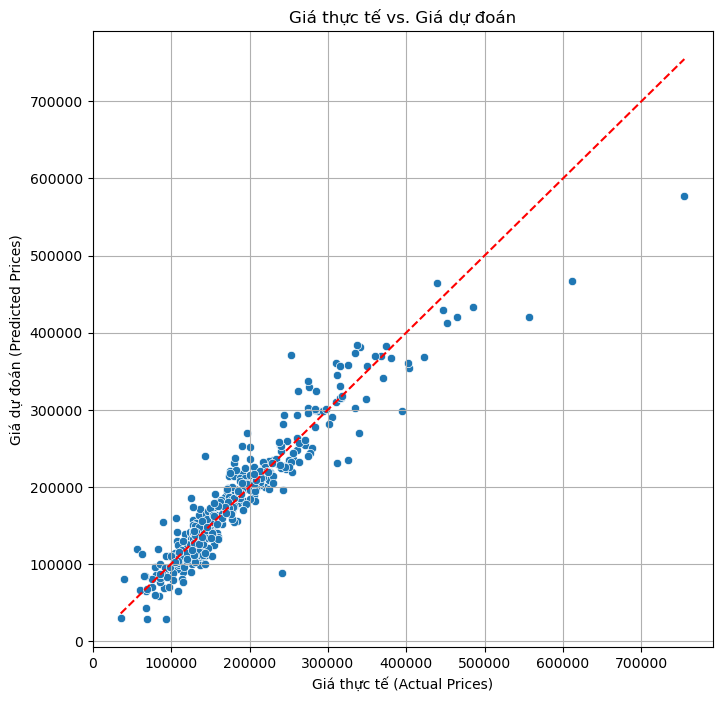

In [17]:
#Trực quan hóa

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Giá thực tế (Actual Prices)")
plt.ylabel("Giá dự đoán (Predicted Prices)")
plt.title("Giá thực tế vs. Giá dự đoán")
# Vẽ đường thẳng y=x. Nếu các điểm nằm càng gần đường này, mô hình càng tốt.
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.grid(True)
plt.show()

## RandomForestRegressor

In [21]:
#Tạo model cần train 
model2 = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("RandomForestRegressor",RandomForestRegressor(random_state = 42))
    ]
)


In [22]:
#Tiến hành train model
model2.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('RandomForestRegressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_cols', ...), ('cat_cols', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [23]:
#In ra các chỉ số đánh giá

y_pred = model2.predict(X_test)
# 1. Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"1.Lỗi tuyệt đối trung bình (MAE): {mae:.2f}")
print(f"==> Trung bình, mô hình dự đoán sai lệch khoảng {mae:.2f} (đơn vị của giá nhà).\n")

# 2. Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"2.Lỗi bình phương trung bình (MSE): {mse:.2f}")
print("==> Chỉ số này khó diễn giải trực tiếp, chủ yếu dùng để so sánh các mô hình.\n")

# 3. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"3.Căn bậc hai lỗi bình phương trung bình (RMSE): {rmse:.2f}")
print(f"==> Độ lệch chuẩn của các lỗi dự đoán là khoảng {rmse:.2f} (đơn vị của giá nhà).\n")

# 4. R-squared (R2) Score
r2 = r2_score(y_test, y_pred)
print(f"4.Hệ số xác định (R-squared): {r2:.4f}")
print(f"==> Mô hình giải thích được {r2:.2%} sự biến động của giá nhà trong tập test.\n")

# 5. Mean Absolute Percentage Error (MAPE)
# Lưu ý: MAPE sẽ bị lỗi nếu y_test có giá trị bằng 0.
if np.any(y_test == 0):
    print("Không thể tính MAPE vì có giá trị thực tế bằng 0.")
else:
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"5.Lỗi phần trăm tuyệt đối trung bình (MAPE): {mape:.4f}")
    print(f"==> Trung bình, dự đoán của mô hình sai lệch khoảng {mape:.2%} so với giá trị thực.\n")

1.Lỗi tuyệt đối trung bình (MAE): 16641.22
==> Trung bình, mô hình dự đoán sai lệch khoảng 16641.22 (đơn vị của giá nhà).

2.Lỗi bình phương trung bình (MSE): 703439220.32
==> Chỉ số này khó diễn giải trực tiếp, chủ yếu dùng để so sánh các mô hình.

3.Căn bậc hai lỗi bình phương trung bình (RMSE): 26522.43
==> Độ lệch chuẩn của các lỗi dự đoán là khoảng 26522.43 (đơn vị của giá nhà).

4.Hệ số xác định (R-squared): 0.8992
==> Mô hình giải thích được 89.92% sự biến động của giá nhà trong tập test.

5.Lỗi phần trăm tuyệt đối trung bình (MAPE): 0.0990
==> Trung bình, dự đoán của mô hình sai lệch khoảng 9.90% so với giá trị thực.



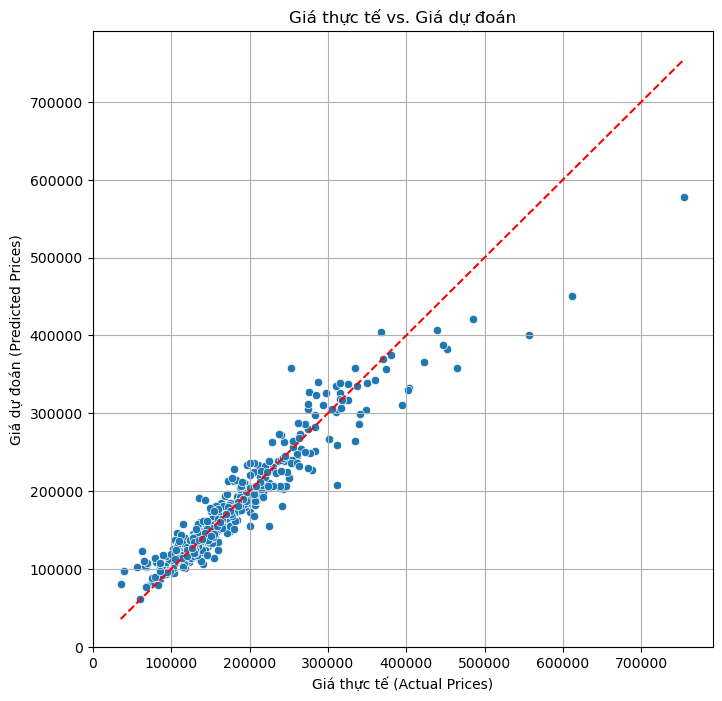

In [24]:
#Trực quan hóa

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Giá thực tế (Actual Prices)")
plt.ylabel("Giá dự đoán (Predicted Prices)")
plt.title("Giá thực tế vs. Giá dự đoán")
# Vẽ đường thẳng y=x. Nếu các điểm nằm càng gần đường này, mô hình càng tốt.
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.grid(True)
plt.show()